<a href="https://colab.research.google.com/github/rabeeqasem/A3C/blob/main/147_dual_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pyproj

     |████████████████████████████████| 6.3 MB 12.0 MB/s 


In [2]:
import numpy as np
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import random
import random
import time
import progressbar
from numpy import linalg as LA
%matplotlib inline
from tqdm.autonotebook import tqdm
import itertools
from collections import deque

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import plotly
import plotly.express as px
import pyproj
import time
import math
import seaborn as sns
import random
from torch.distributions import Categorical,Normal,Bernoulli
from IPython.display import clear_output


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Oct 16 21:49:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import sys
from google.colab import drive
drive.mount('/content/drive/')
sys.path.insert(0,'/content/drive/MyDrive/Rabee_qasem_AAUP/code/Data_Retrieval')

# Opening JSON file 
f = open('/content/drive/MyDrive/Rabee_qasem_AAUP/code/Data_Retrieval/final2.json') 
  
# returns JSON object as  
# a dictionary 
data_str_key = json.load(f)

Mounted at /content/drive/


In [4]:
#solve the issue of string keys and convert it to numbers
data={}
for k,v in data_str_key.items():
  data[int(k)]=v

In [5]:
#reconstruct the graph
h = nx.Graph()
for key in data.keys():
  if data[key]['type']=='way':
    for i in range(len(data[key]['nodes'])-1):
      if 'tags' in data[key] and 'name' in data[key]['tags']:
          h.add_edge(data[key]['nodes'][i],data[key]['nodes'][i+1],parent=data[key]['id'],label=data[key]['tags']['name'])
      else:
        h.add_edge(data[key]['nodes'][i],data[key]['nodes'][i+1],parent=data[key]['id'])

In [6]:
geod = pyproj.Geod(ellps='WGS84')

# Compute distance among the two nodes indexed[s] indexed[d] using LON and LAT
for s,d in tqdm(h.edges()):
  azimuth1, azimuth2, distance = geod.inv(data[s]['lon'],data[s]['lat'],data[d]['lon'],data[d]['lat'])
  h.edges[s,d]['weight'] = distance

  0%|          | 0/3527 [00:00<?, ?it/s]

In [7]:
def get_neighbors(node):
  neighbors=[i for i in h.neighbors(node)]
  return len(neighbors)

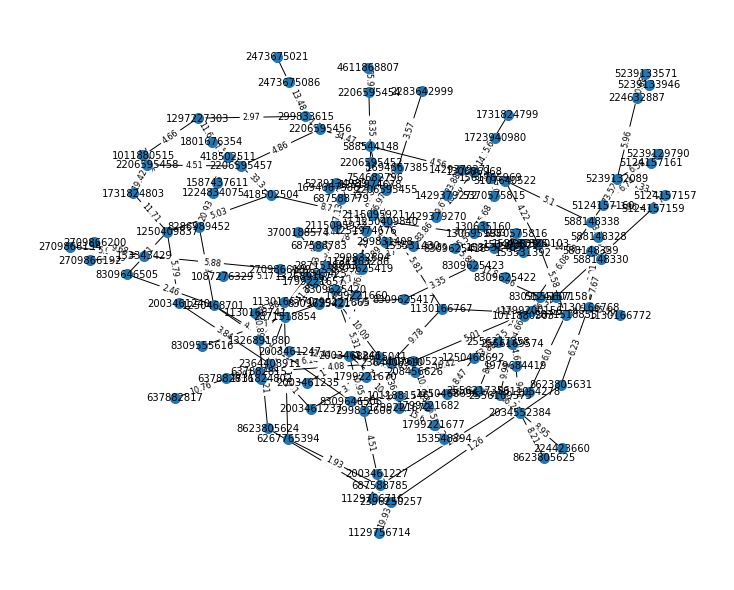

143


In [8]:
nodex={}
for node in h.nodes:
  nodex[node]=get_neighbors(node)

mx = max(nodex.values())
[k for k, v in nodex.items() if v == mx]


starter_node=[2206595456,
 2206595457,
 2871518853,
 2871518854,
 2871518855,
 2556217356,
 8286989452,
 2556217358,
 6267765394,
 588544148,
 1251974676,
 1251974678,
 1799221657,
 299832604,
 1799221660,
 299832606,
 1799200156,
 3700188574,
 1799221665,
 1731824802,
 153531430,
 8309646505,
 8309646506,
 754682796,
 1129756716,
 687588783,
 687588785,
 208456626,
 1799221682,
 1011880503,
 5239132089,
 637882815,
 153343425,
 8311054278,
 2206595455,
 4963500103,
 1429379270,
 1011881546,
 3107640523,
 3107640522,
 2709866189,
 2364408910,
 2364408911,
 8309625418,
 8309625419,
 8309625420,
 1250468692,
 1131363286,
 1250468696,
 1250468701,
 2556169573,
 5124157158,
 5124157159,
 418502504,
 5124157157,
 5124157160,
 2003461227,
 5124157161,
 1250409837,
 1130166767,
 1250409840,
 2115095921,
 2115095922,
 2003461235,
 299831408,
 2003461237,
 588148339,
 1130166770,
 2206595452,
 2003461246,
 2003461247]
node_list=[]
for sn in starter_node:
  node_list.append(sn)
  for node in h.neighbors(sn):
    node_list.append(node)
    for snode in h.neighbors(node):
      node_list.append(snode)
dictt={}
for node in node_list:
  c=0
  for subnode in node_list:
    if subnode in h[node]:
      c+=1
  dictt[node]=c

g = h.subgraph(dictt.keys())
tt=nx.get_edge_attributes(g, 'weight')
graph_labels=nx.get_edge_attributes(g, 'weight')
# Plotting the Graph
plt.figure(figsize=(10,8))
pos = nx.spring_layout(g)
edge_labels = nx.get_edge_attributes(g, 'weight')
for label in edge_labels:
  edge_labels[label]=round(edge_labels[label],2)
nx.draw(g, pos, node_size=100)
nx.draw_networkx_edge_labels(g, pos, edge_labels, font_size=8)
nx.draw_networkx_labels(g, pos, font_size=10)
plt.show()
print(len(g.nodes()))

## DQN

In [10]:
'''
class Network(nn.Module):
  def __init__(self,input_dim,n_action):
    super(Network,self).__init__()
    self.f1=nn.Linear(input_dim,128)
    self.f2=nn.Linear(128,64)
    self.f3=nn.Linear(64,32)
    self.f4=nn.Linear(32,n_action)
    #self.loss=nn.MSELoss()
    self.device=T.device('cuda' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self,x):
    x=F.relu(self.f1(x))
    x=F.relu(self.f2(x))
    x=F.relu(self.f3(x))
    x=self.f4(x)
    return x

  def act(self,obs):
    #state=T.tensor(obs).to(device)
    state=obs.to(self.device)
    actions=self.forward(state)
    action=T.argmax(actions).item()

    return action
'''

"\nclass Network(nn.Module):\n  def __init__(self,input_dim,n_action):\n    super(Network,self).__init__()\n    self.f1=nn.Linear(input_dim,128)\n    self.f2=nn.Linear(128,64)\n    self.f3=nn.Linear(64,32)\n    self.f4=nn.Linear(32,n_action)\n    #self.loss=nn.MSELoss()\n    self.device=T.device('cuda' if T.cuda.is_available() else 'cpu')\n    self.to(self.device)\n\n  def forward(self,x):\n    x=F.relu(self.f1(x))\n    x=F.relu(self.f2(x))\n    x=F.relu(self.f3(x))\n    x=self.f4(x)\n    return x\n\n  def act(self,obs):\n    #state=T.tensor(obs).to(device)\n    state=obs.to(self.device)\n    actions=self.forward(state)\n    action=T.argmax(actions).item()\n\n    return action\n"

In [11]:
class QNetwork(nn.Module):
    def __init__(self,input_dim,n_action):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(64, 256)
        self.fc_adv = nn.Linear(64, 256)

        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, n_action)
        self.device=T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = T.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

    def select_action(self, state):
        with T.no_grad():
            Q = self.forward(state)
            action_index = T.argmax(Q, dim=1)
        return action_index.item()

In [12]:
device=T.device('cuda' if T.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
num_states = len(g.nodes)**2
### if we need to train a specific set of nodes for ex 10 we *10
num_actions = len(g.nodes)
print("Expected number of States are: "+str(num_states))
print("Expected number of action are: "+str(num_actions))

Expected number of States are: 20449
Expected number of action are: 143


In [14]:
'''
#num_action*2=when we would like to convert the state into onehotvector we need to concatinate the two vector 22+22
online=Network(num_actions*2,num_actions)
target=Network(num_actions*2,num_actions)
target.load_state_dict(online.state_dict())
optimizer=T.optim.Adam(online.parameters(),lr=1e-2)
'''

'\n#num_action*2=when we would like to convert the state into onehotvector we need to concatinate the two vector 22+22\nonline=Network(num_actions*2,num_actions)\ntarget=Network(num_actions*2,num_actions)\ntarget.load_state_dict(online.state_dict())\noptimizer=T.optim.Adam(online.parameters(),lr=1e-2)\n'

In [15]:
#num_action*2=when we would like to convert the state into onehotvector we need to concatinate the two vector 22+22
online=QNetwork(num_actions*2,num_actions)
target=QNetwork(num_actions*2,num_actions)
target.load_state_dict(online.state_dict())
optimizer=T.optim.Adam(online.parameters(),lr=1e-2)

In [18]:
#create a dictionary that have encoded index for each node
#to solve this isssu
#reset()=476562122273
#number of state < 476562122273
enc_node={}
dec_node={}
for index,nd in enumerate(g.nodes):
  enc_node[nd]=index
  dec_node[index]=nd

In [9]:


def state_enc(dst, end,n=len(g.nodes)):
    return dst+n*end
    

def state_dec(state,n=len(g.nodes)):
    dst = state%n
    end = (state-dst)/n
    return dst, int(end)


def reset():
  state=state_enc(enc_node[153531392],enc_node[5239133571])
  return state


def wayenc(node,action):
  #encoded
  if action in g[node]:
    rw=g[node][action]['weight']*-1
    return rw,True
  rw=-1000
  return rw,False

def slop_reward(current_node,new_node):
  slop=data[g[current_node][new_node]['parent']]['slop']
  result=np.power(slop,3)
  return result

def road_type_reward(current_node,new_node,pref_road_type:list):
  road_type_between_two_nods=data[g[current_node][new_node]['parent']]['tags']['highway']
  if road_type_between_two_nods in pref_road_type:
    if "cycleway" in pref_road_type:
      return 100
    else:
      return 50
  else:
    return -50

def lane_reward(current_node,new_node):
  parent_id=g[current_node][new_node]['parent']
  if data[parent_id].__contains__('tags'):
    if data[parent_id]['tags'].__contains__('lanes'):
      num_lanes=int(data[parent_id]['tags']['lanes'])
      reward=num_lanes*-10
      return reward
    else: return 0
  else:return 0

def light_reward(current_node,new_node):
  parent_id=g[current_node][new_node]['parent']
  if data[parent_id].__contains__('tags'):
    if data[parent_id]['tags'].__contains__('lit'):
      light_type=data[parent_id]['tags']['lit']
      if light_type=="yes":
        reward=50
      elif light_type in ['24/7','sunset-sunrise','automatic','operating times']:
        reward=10
      elif light_type in ['no','disused']:
        reward=-20
      return reward
    else: return 0
  else:return 0

def max_speed_reward(current_node,new_node):
  parent_id=g[current_node][new_node]['parent']
  if data[parent_id].__contains__('tags'):
    if data[parent_id]['tags'].__contains__('maxspeed'):
      max_speed_value=int(data[parent_id]['tags']['maxspeed'])
      reward=max_speed_value*-1
      return reward
    else:return 0
  else: return 0

def surface_type_reward(current_node,new_node,pref_surface_type:list):
  parent_id=g[current_node][new_node]['parent']
  if data[parent_id].__contains__('tags'):
    if data[parent_id]['tags'].__contains__('surface'):
      surface_type_between_two_nodes=data[g[current_node][new_node]['parent']]['tags']['surface']
      if surface_type_between_two_nodes in pref_surface_type:
        return 50
      else:
        return -50
    else:return 0 
  else:return 0


def tracer_number_reward(current_node,new_node):
  parent_id=g[current_node][new_node]['parent']
  trace_number_edge =data[parent_id]['trace_number']
  reward=-10*trace_number_edge
  return reward

def rw_function(node,action):
  node=dec_node[node]
  action=dec_node[action]
  beta0=wights[0][0] #between 1 and 0
  beta1=wights[0][1]
  beta2=wights[0][2]
  beta3=wights[0][3]
  beta4=wights[0][4]
  beta5=wights[0][5]
  beta6=wights[0][6]
  beta7=wights[0][7]

  rw0,link=wayenc(node,action)

  if link:
    rw1=slop_reward(node,action)
    rw2=road_type_reward(node,action,['primary','residential'])
    rw3=lane_reward(node,action)
    rw4=light_reward(node,action)
    rw5=max_speed_reward(node,action)
    rw6=surface_type_reward(node,action,['asphalt'])
    rw7=tracer_number_reward(node,action)
    frw=beta0*rw0 + beta1*rw1+ beta2*rw2  + beta3*rw3+ beta4*rw4 +rw5*beta5 + rw6*beta6+rw7*beta7
  else:
    frw=rw0


  return frw,link

def step(state,action):
  done=False
  #end=1731824802

  current_node , end = state_dec(state)

  new_state = state_enc(action,end)
  rw,link=rw_function(current_node,action)

  if not link:
      new_state = state
      return new_state,rw,False  

  elif action == end:
      rw = 10000 #500*12
      done=True
    
  return new_state,rw,done


def state_to_vector(current_node,end_node):
  n=len(g.nodes)
  source_state_zeros=[0.]*n
  source_state_zeros[current_node]=1

  end_state_zeros=[0.]*n
  end_state_zeros[end_node]=1.
  vector=source_state_zeros+end_state_zeros
  return vector


    

#return a list of list converted from state to vectors
def list_of_vecotrs(new_obses_t):
  list_new_obss_t=new_obses_t.tolist()
  #convert to integer
  list_new_obss_t=[int(v) for v in list_new_obss_t]
  vector_list=[]
  for state in list_new_obss_t:
    s,f=state_dec(state)
    vector=state_to_vector(s,f)
    vector_list.append(vector)
  return vector_list

def dqn_clipped_loss(current_q, target_q, target_q_a_max, gamma):
    # max[current_q, delta^2 + target_q] + max[delta,gamma*(target_q_a_max)^2]
    delta = current_q - target_q
    left_max = T.max(current_q, T.pow(delta, 2) + target_q)
    right_max = T.max(delta, gamma * T.pow(target_q_a_max, 2))
    loss = T.mean(left_max + right_max)

    return loss

**fill the replay buffer with total random**

In [18]:
def get_neighbors(obs):
  current_node,end=state_dec(obs)
  neighbors=[enc_node[i] for i in g.neighbors(dec_node[current_node])]
  return neighbors

In [19]:
np.random.dirichlet(np.ones(8),size=1)

array([[0.0299915 , 0.08138892, 0.02815376, 0.08167734, 0.00483927,
        0.19765662, 0.49603154, 0.08026106]])

In [20]:
#wights=np.random.dirichlet(np.ones(8),size=1)
wights=np.array([[0.07051304, 0.14832941, 0.03459922, 0.06227937, 0.15332614,
        0.2594585 , 0.18294566, 0.08854866]])
#replay_buffer=[]
rew_buffer=[0]
penalties=[]
episode_reward=0.0
#batch_size=num_actions*2
batch_size=32
buffer_size=1000000 
min_replay_size=int(buffer_size*0.25)

target_update_freq=1000
flag=0
action_list=np.arange(0,len(g.nodes)).tolist()
replay_buffer=deque(maxlen=min_replay_size)


#populate the experience network 
obs=reset()
#obs,end=state_dec(start,len(g.nodes))
for _ in tqdm(range(min_replay_size)):
  #action=np.random.choice(action_list)
  #
  neighbors=get_neighbors(obs)
  action=np.random.choice(neighbors)
  
  new_obs,rew,done=step(obs,action)
  transition=(obs,action,rew,done,new_obs)
  replay_buffer.append(transition)
  obs=new_obs
  if done:
    obs=reset()


  0%|          | 0/250000 [00:00<?, ?it/s]

In [21]:
for bf in replay_buffer:
  if bf[3]==True:
    print(bf)

(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 107, 10000, True, 15408)
(15314, 10

In [22]:
#main training loop
obs=reset()
episodes=2000000
start=1
end=0.1
decay=episodes
gamma=0.99
epsilon=0.5



gamma_list=[]
mean_reward=[]
done_location=[]
loss_list=[]
number_of_episodes=[]
stat_dict={'episodes':[],'epsilon':[],'explore_exploit':[],'time':[]}


#for i in tqdm(range(episodes)):
for i in tqdm(range(episodes)):

  itr=0
  #epsilon=np.interp(i,[0,decay],[start,end])
  #gamma=np.interp(i,[0,decay],[start,end])
  epsilon=np.exp(-i/(episodes/2))
  rnd_sample=random.random()

  stat_dict['episodes'].append(i)
  stat_dict['epsilon'].append(epsilon)

  #choose an action
  if rnd_sample <=epsilon:
    #action=np.random.choice(action_list)
    neighbors=get_neighbors(obs)
    action=np.random.choice(neighbors)
    stat_dict['explore_exploit'].append('explore')

  else:
    source,end=state_dec(obs)
    v_obs=state_to_vector(source,end)
    t_obs=T.tensor([v_obs]).to(device)
    action=online.select_action(t_obs)
    stat_dict['explore_exploit'].append('exploit')

  #fill transition and append to replay buffer

  
  new_obs,rew,done=step(obs,action)

  transition=(obs,action,rew,done,new_obs)
  replay_buffer.append(transition)
  obs=new_obs
  episode_reward+=rew


  if done:
    obs=reset()
    rew_buffer.append(episode_reward)
    episode_reward=0.0
    done_location.append(i)


  #start gradient step
  batch_size=32
  transitions=random.sample(replay_buffer,batch_size)
  obses=np.asarray([t[0] for t in transitions])
  actions=np.asarray([t[1] for t in transitions])
  rews=np.asarray([t[2] for t in transitions])
  dones=np.asarray([t[3] for t in transitions])
  new_obses=np.asarray([t[4] for t in transitions])


  obses_t=T.as_tensor(obses,dtype=T.float32).to(device)
  actions_t=T.as_tensor(actions,dtype=T.int64).to(device).unsqueeze(-1)
  rews_t=T.as_tensor(rews,dtype=T.float32).to(device)
  dones_t=T.as_tensor(dones,dtype=T.float32).to(device)
  new_obses_t=T.as_tensor(new_obses,dtype=T.float32).to(device)

  list_new_obses_t=T.tensor(list_of_vecotrs(new_obses_t)).to(device)
  target_q_values=target(list_new_obses_t)##


  max_target_q_values=target_q_values.max(dim=1,keepdim=False)[0]
  targets=rews_t+gamma*(1-dones_t)*max_target_q_values
  targets=targets.unsqueeze(-1)
  
  list_obses_t=T.tensor(list_of_vecotrs(obses_t)).to(device)
  q_values=online(list_obses_t)
  action_q_values=T.gather(input=q_values,dim=1,index=actions_t)

  
  #warning UserWarning: Using a target size (torch.Size([24, 24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
  loss=nn.functional.mse_loss(action_q_values,targets)
  #loss=dqn_clipped_loss(action_q_values,targets,max_target_q_values,gamma)
  loss_list.append(loss.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #plot
  mean_reward.append(np.mean(rew_buffer))
  number_of_episodes.append(i)
  gamma_list.append(gamma)
  dec = {'number_of_episodes':number_of_episodes,'mean_reward':mean_reward,'gamma':gamma_list}
  #clear_output(wait=True)
  #sns.lineplot(data=dec, x="number_of_episodes", y="mean_reward")
  #plt.show()

  

  if i % target_update_freq==0:
    target.load_state_dict(online.state_dict())
  if i % 1000 ==0:
    print('step',i,'avg rew',round(np.mean(rew_buffer),2))
    pass
  if i==5000:
    pass


  0%|          | 0/2000000 [00:00<?, ?it/s]

step 0 avg rew 0.0
step 1000 avg rew 0.0
step 2000 avg rew 0.0
step 3000 avg rew 0.0
step 4000 avg rew 0.0
step 5000 avg rew 0.0
step 6000 avg rew -17666.3
step 7000 avg rew -17666.3
step 8000 avg rew -11740.13
step 9000 avg rew -11740.13
step 10000 avg rew -8249.69
step 11000 avg rew -8249.69
step 12000 avg rew -12174.61
step 13000 avg rew -10366.72
step 14000 avg rew -10114.56
step 15000 avg rew -10114.56
step 16000 avg rew -10114.56
step 17000 avg rew -10114.56
step 18000 avg rew -16035.94
step 19000 avg rew -17195.4
step 20000 avg rew -14766.48
step 21000 avg rew -14166.05
step 22000 avg rew -14166.05
step 23000 avg rew -14166.05
step 24000 avg rew -14166.05
step 25000 avg rew -14166.05
step 26000 avg rew -23124.28
step 27000 avg rew -23124.28
step 28000 avg rew -25631.72
step 29000 avg rew -25469.44
step 30000 avg rew -25469.44
step 31000 avg rew -25469.44
step 32000 avg rew -25469.44
step 33000 avg rew -30086.13
step 34000 avg rew -29168.7
step 35000 avg rew -29010.57
step 36000 

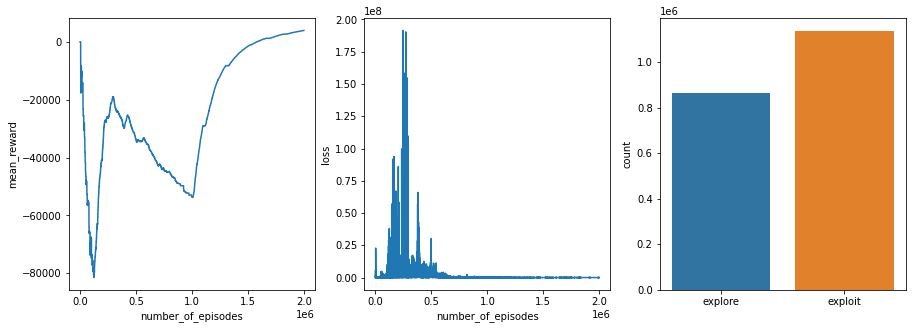

In [23]:
dec = {'number_of_episodes':number_of_episodes,'mean_reward':mean_reward,'gamma':gamma_list,'loss':loss_list,'explore_exploit':stat_dict['explore_exploit']}
fig, ax =plt.subplots(1,3,figsize=(15,5))
sns.lineplot(data=dec, x="number_of_episodes", y="mean_reward",ax=ax[0])
sns.lineplot(data=dec, x="number_of_episodes", y="loss",ax=ax[1])
sns.countplot(data=dec,x='explore_exploit', ax=ax[2])

plt.show()

In [25]:

obs=reset()
done=False
sp=[obs]
while not done:
  source,end=state_dec(obs)
  v_obs=state_to_vector(source,end)
  t_obs=T.tensor([v_obs]).to(device)
  action=target.select_action(t_obs)
  new_obs,rw,done=step(obs,action)
  sp.append(new_obs)
  obs=new_obs
sp


[15301,
 15302,
 15323,
 15308,
 15437,
 15348,
 15422,
 15411,
 15413,
 15345,
 15321,
 15392,
 15391,
 15304,
 15313,
 15379,
 15427,
 15314,
 15408]

In [19]:
ddqn=[15301,
 15302,
 15323,
 15308,
 15437,
 15348,
 15422,
 15411,
 15413,
 15345,
 15321,
 15392,
 15391,
 15304,
 15313,
 15379,
 15427,
 15314,
 15408]
for state in ddqn:
  current,end=state_dec(state)
  print(dec_node[current])

153531392
153531403
8309625418
153531430
1131363286
2871518853
687588783
1799221657
1799221660
2003461246
1011881546
1250468696
1250468692
2556217358
1011880503
5124157160
5239132089
224632887
5239133571


In [28]:
#state=state_enc(enc_node[153531392],enc_node[5239133571])
  
shp=[]
for node in nx.shortest_path(g,153531392,5239133571):
  state=state_enc(enc_node[node],enc_node[5239133571])
  shp.append(state)
shp


[15301,
 15302,
 15323,
 15308,
 15335,
 15306,
 15386,
 15413,
 15345,
 15424,
 15391,
 15304,
 15313,
 15379,
 15427,
 15314,
 15408]

In [ ]:
print(len(shp))
print(len(sp))
